In [14]:
#importing all necessary modules

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

import math
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

sns.set_theme()
sns.set_palette("deep")
RANDOM_SEED = 42

In [15]:
#1: selecting relevant features

master = [] #Initialize list to store the relevant data in

#edited according to which files needed processing
files = ['20152016.csv', "2017onwards.csv"] ##This line to select out the 2015-2019 sales. Comment off if running another year set
#files = ['19901999.csv', '20002012.csv', '20122014.csv'] #This line to select out the 1990-2014 sales. Comment off if running another year set

filelengths = [] #i added this as an add on to the number indexing
for filename in files:
  counter = 0
  with open(filename, 'r') as f:
    header = next(f)
    for row in f:
      lis = row.strip().split(',')
      lis[0] = lis[0][0:4] + lis[0][5:] #processing string with '-' into an integer value
      line = [float(lis[0]), lis[2], float(lis[6]), lis[7], float(lis[8]), float(lis[10])] #referencing relevent features and adding them [For dataset of 2017onwards, last val index +1]
      line[3] = line[3].upper()
      master.append(line)
      counter += 1
    filelengths.append(counter)



#This line to select out the 2015-2019 sales. Comment off if running another year set
master = master[:filelengths[0]+64256]

#initialize values for better and more intuitive referencing of indexes with minimal confusion
month, flat_type, floor_area_sqm, flat_model, lease_commence_date, resale_price, unemployment_rate, real_gdp, distance_to_cbd, population_size = 0,1,2,3,4,5,6,7,8,9

#2: encoding categorical values for flat_model and flat_type
enc = OrdinalEncoder()
X = [['1 ROOM'], ['2 ROOM'], ['3 ROOM'], ['4 ROOM'], ['5 ROOM'], ['EXECUTIVE'], ['MULTI-GENERATION'], ['MULTI GENERATION']]
X_2 = [['SIMPLIFIED'], ['IMPROVED'], ['MODEL A'], ['APARTMENT'], ['NEW GENERATION'], ['STANDARD'], ['MAISONETTE'], ['MODEL A-MAISONETTE'], ['TERRACE'], ['IMPROVED-MAISONETTE'], ['PREMIUM APARTMENT'], ['MULTI GENERATION'], ['2-ROOM'], ['MODEL A2'], ['PREMIUM MAISONETTE'], ['ADJOINED FLAT'], ['TYPE S1'], ['DBSS'], ['PREMIUM APARTMENT LOFT'], ['TYPE S2'], ['3GEN']]

enc.fit(X)
result = enc.transform([[row[flat_type]] for row in master]) #flat type encoding
enc.fit(X_2)
result2 = enc.transform([[row[flat_model]] for row in master]) #flat model encoding

for row in range(len(master)):
  master[row][flat_type] = result[row][0]
  master[row][flat_model] = result2[row][0]



FileNotFoundError: [Errno 2] No such file or directory: '20152016.csv'

In [ ]:
#3: adding unemployment rate as a feature to the master dataset
import csv
#list of sublists seperated by quarters
months = [['01', '02', '03'], ['04', '05', '06'], ['07', '08', '09'], ['10', '11', '12']]

dic = {} #dic will store manually created string keys ('20241Q'...'19904Q') that will reference sublists consisting of months(from the months list) in that specific quarter.
#eg. {'20241Q':['202401.0', '202402.0', '202403.0']}
for i in range(1990, 2025):
  for j in range(1, 5):
    dic[str(i)+str(j)+'Q'] = []
    for m in months[j-1]:
      dic[str(i)+str(j)+'Q'] += [float(str(i)+m)]

finaldic = {}

with open('UnemploymentRateEndOfPeriodQuarterlySeasonallyAdjusted.csv', 'r') as f:
  masterr = [] #this list will contain 2 rows: row 1 contains the quarterly label year values such as '20241Q'. row 2 contains the unemployment rate for that quarter such as '1.7'
  for row in f:
    row = row.strip().split(',')
    masterr.append(row[1:]) #removing the titles total unemployment rate, resident unemployment rate
  masterr = masterr[:2] #removing resident and citize unemployment rate
  masterr[1] = masterr[1][1:] #removing the title ' (SA)"'

#as the file only contains unemployment rates from 1992-2024,
#through research(https://stats.mom.gov.sg/iMAS_Tables/Times%20Series%20Table/mrsd_14_Historical_Unemployment_Rate_28Jan21.xlsx)
#we will be manually inserting unemployment rates as 1.7 for each quarter in 1990 and 1991.
for i in range(1, 5):
  masterr[0].append('1990'+str(i)+'Q')
  masterr[0].append('1991'+str(i)+'Q')
  masterr[1] += [1.7, 1.7]

#for each quarter label in the first row, and for each key in dic, if they equate to each other,
#we will insert into finaldic, (the values in the sublist that the key in dic refers to) as the key
#that references the (unemployment rate for that month)value.
for item in masterr[0]:
  for row in dic:
    if item == row:
      for i in dic[row]:
        finaldic[i] = float(masterr[1][masterr[0].index(item)])

#adding the correct unemployment rate to the correct month in the dataset based on the float key of the month in finaldic
for row in master:
  for item in finaldic:
    if row[month] == item:
      row += [finaldic[item]]


In [ ]:
#4: calculating remaining lease by performing the following: 99 - (current year - lease commencement date)
for row in master:
  result = 99-(int(str(row[month])[:4])-int(str(row[lease_commence_date])[:4]))
  row[lease_commence_date] = result

remaining_lease = lease_commence_date

In [ ]:
#5 inserting real gdp into the dataset
with open('M015651.csv', 'r') as f:
  finalliz = f.readlines()
  year = (finalliz[10].strip().split(','))[1:] #removing irrelevant data and the header value to obtain the years
  r = year.index('1990 1Q ') #finding the index to cut off and obtain relevant years
  year = year[:r+1]
  gdp = (finalliz[11].strip().split(','))[1:] #removing irrelevant data and the header value to obtain the gdp
  gdp = gdp[:r+1]

for row in range(len(year)):
  year[row] = year[row][:4] + year[row][5:7] #removing spaces from the quearterly year labels

finalfinaldic = {}

#for each quarter label in the year list, and for each key in dic, if they equate to each other,
#we will insert into finalfinaldic, (the values in the sublist that the key in dic refers to) as the key
#that references the (gdp)value in the gdp list.
for item in year:
  for row in dic:
    if item == row:
      for i in dic[row]:
        finalfinaldic[i] = float(gdp[year.index(item)])

#adding the correct gdp rate to the correct month in the dataset based on the float key of the month in finaldic
for row in master:
  for item in finalfinaldic:
    if row[month] == item:
      row += [finalfinaldic[item]]

In [ ]:
#6: inserting the distance to cbd

#Initializes working data array
data = []

for filename in files:
  with open(filename,'r') as f:
    i = 0
    for row in f:
      if i != 0:
        data.append(row.strip('\n').split(','))
      i += 1

# For selecting data 2020-2024, comment off if other years
#data = data[64257:196985]
# For selecting data 2015-2019, comment off if other years
data = data[:filelengths[0]+64256]

def get_lat_lon(address):
    """
    Gets the latitude and longitude of the street using Nominatim API
    """
    #Initializes the geocoder and collects the location information
    geolocator = Nominatim(user_agent="Jupyter_AI_Project_HomeBros")
    location = geolocator.geocode(address, timeout=10)

    #Begins up to 5 attempts to find location, increasing delay time each attempt in case of timeout
    for attempt in range(5):
        delay = 1
        try:
            location = geolocator.geocode(address, timeout=10)

            #Checks if location found. If not, prints address and returns None.
            #When not found, address was examined to identify why. (During preprocessing. Resulted in the many if statements in the preprocessing function)
            if location:
                return location.latitude, location.longitude
            else:
                print(address)
                return None, None

        except GeocoderTimedOut:
            print(f"Timeout on attempt {attempt+1} for '{address}'... retrying in {delay}s.")
            time.sleep(delay)
            delay += 1


def haversine(lat1, lon1, lat2, lon2):
    """
    Calculates shortest distance to CBD in kilometres, accounting for the curve of the Earth
    """
    R = 6371  # Earth's radius in kilometers
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return round(distance,3)

def preprocessing(data, streets, unique_streets):
  """
  Handles shortforms and missing streets
  """
  for row in data[1:]:
    new_strt = row[4]

    # Storage to retrieve indexes later
    if new_strt not in streets:
      streets.append(new_strt)

    # Processing
    if " NTH " in new_strt:
      new_strt = new_strt.replace(" NTH ", " NORTH ")
    if " NTH" in new_strt:
      new_strt = new_strt.replace(" NTH", " NORTH")
    if " STH " in new_strt:
      new_strt = new_strt.replace(" STH ", " SOUTH ")
    if " ST " in new_strt:
      new_strt = new_strt.replace(" ST ", " STREET ")
    if " RD " in new_strt:
      new_strt = new_strt.replace(" RD ", " ROAD ")
    if "BT " in new_strt:
      new_strt = new_strt.replace("BT ", "BUKIT ")
    if " BT " in new_strt:
      new_strt = new_strt.replace(" BT ", " BUKIT ")
    if " ST" == new_strt[-3:]:
      new_strt = new_strt[:-3] + " STREET"
    if " RD" == new_strt[-3:]:
      new_strt = new_strt[:-3] + " ROAD"
    if new_strt == "JLN MEMBINA BARAT":
      new_strt = "Central Green Condo" #Road no longer exists
    if "JLN " in new_strt:
      new_strt = new_strt.replace("JLN ", "JALAN ")
    if "LOR " in new_strt:
      new_strt = new_strt.replace("LOR ", "LORONG ")
    if " AVE " in new_strt:
      new_strt = new_strt.replace(" AVE ", " AVENUE ")
    if " AVE" == new_strt[-4:]:
      new_strt = new_strt[:-4] + " AVENUE"
    if " DR " in new_strt:
      new_strt = new_strt.replace(" DR ", " DRIVE ")
    if " DR" == new_strt[-3:]:
      new_strt = new_strt[:-3] + " DRIVE"
    if "C'WEALTH" in new_strt:
      new_strt = new_strt.replace("C'WEALTH", "COMMONWEALTH")
    if "TG " in new_strt:
      new_strt = new_strt.replace("TG ", "TANJONG ")
    if new_strt == "KG BAHRU HILL":
      new_strt = "SPOONER ROAD" #Road no longer exists
    elif "KG " in new_strt:
      new_strt = new_strt.replace("KG ", "KAMPONG ")
    if "UPP " in new_strt:
      new_strt = new_strt.replace("UPP ", "UPPER ")
    if "BUANGKOK SOUTH FARMWAY 1" == new_strt:
      new_strt = "BUANGKOK" #Road no longer exists

    #If street not already in unique_streets, add it
    if new_strt not in unique_streets:
      unique_streets.append(new_strt)
  return


#Selects unique streets for processing, and stores streets for returning to initial dataset
streets = []
unique_streets = []
preprocessing(data[1:], streets, unique_streets)
print("Streets split")

#Converts each item in streets to a list in the format [street_name, latitude, longitude]
i = 0
for row in unique_streets:
  address = row
  lat, lon = get_lat_lon(address)
  unique_streets[i] = [row, lat, lon]
  i += 1
print("Coordinates calculated")

# Initialized the values for CBD's latitude and longitude
CBD = [1.2812, 103.8503]
# Calculates distance to CBD of each location
for row in unique_streets:
  dist = haversine(CBD[0], CBD[1], row[1], row[2])
  row.append(dist)
print("Distance calculated")

# Adjusts main dataset to reflect dist to CBD instead of street name
for row in data:
  if streets.index(row[4]) > len(unique_streets):
    print("Error")
    print(row[4]) #Preprocessing checks
  else:
    record = unique_streets[streets.index(row[4])]
    row[4] = record[3]
print('Data attached to current dataset')

# Attached data to main working dataset
for row in range(len(data)):
  master[row].append(data[row][4])
print("Data attached to main dataset")

In [ ]:
#7 Insert population into dataset
with open('M810811.csv', 'r') as f:
  finalliz = f.readlines()
  year = (finalliz[10].strip().split(','))[1:] #removing irrelevant data and the header value to obtain the years
  population = (finalliz[11].strip().split(','))[1:] #removing irrelevant data and the header value to obtain the gdp

months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
finalpop = []
finalyear = []
for row in year:
  for m in months:
    finalyear += [(row.strip()+m)]

for pop in population:
  for i in range(12):
    finalpop.append(pop)

#adding the correct unemployment rate to the correct month in the dataset based on the float key of the month in finaldic
for row in master:
  for item in finalyear:
    if row[month] == float(item):
      row += [float(finalpop[finalyear.index(item)])]


In [ ]:
#write to the storage dataset - testing dataset
with open("20152019processedtesting.csv","w") as f:
    for row in master:
        for each in row:
            if type(each) != str:
                each = str(each)
            f.write(each)
            f.write(",")
        f.write("\n")


In [ ]:
#write to the storage dataset - training and validation dataset
with open("19902014processedtesting.csv","w") as f:
    for row in master:
        for each in row:
            if type(each) != str:
                each = str(each)
            f.write(each)
            f.write(",")
        f.write("\n")


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb


with open('19902014processedtraining.csv', 'r') as f:
  rows_1990_2009 = []
  rows_2010_2014 = []

  for row in f:
    row = row.strip()
    #print(row)

    if row[:3]== '201':
      rows_2010_2014.append(row)
    else:
      rows_1990_2009.append(row)


# Write 1990–2009 data
with open('19902009processedtraining.csv', 'w') as f1:
  for row in rows_1990_2009:
    f1.write(row + '\n')
# Write 1990–2009 data
with open('20102014processedvalidation.csv', 'w') as f1:
  for row in rows_2010_2014:
    f1.write(row + '\n')
train_file = '19902009processedtraining.csv'
val_file = '20102014processedvalidation.csv'
test_file = '20152019processedtesting.csv'  # Ensure this exists or load later

#sets contain all 3 necessary datasets for the various purposes
sets = [train_file, val_file, test_file]
finalmaster = []
for i in range(len(sets)):
  with open(sets[i], 'r') as f:
    master = [] #list to have relevant features from the resale flat price dataset
    for row in f:
      if len(row) > 1:
        lis = row.strip().split(',')
        master.append(lis)
  y = []
  resale_price = 5 #index of resale_price
  for row in master:
    y.append(float(row[resale_price]))
  X = []
  for row in master:
    r = row[:resale_price]+row[resale_price+1:]
    for val in range(len(r)):
      if r[val] != '':
        r[val] = float(r[val])
      else:
        r.pop(val)
    X.append(r)
  finalmaster.append([X, y])
  print(i)

# === LOAD DATA ===
X_train_raw = np.array(finalmaster[0][0])
y_train = np.array(finalmaster[0][1])
X_val_raw = np.array(finalmaster[1][0])
y_val = np.array(finalmaster[1][1])
X_test_raw = np.array(finalmaster[2][0])
y_test = np.array(finalmaster[2][1])


# === FEATURE SCALING ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

# === MODEL AND TUNING ===
param_grid = {
    'n_estimators': [25, 75, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 7, 10]
}

xgbr = xgb.XGBRegressor(objective='reg:absoluteerror', n_jobs=-1)
grid_search = GridSearchCV(
    estimator=xgbr,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search.fit(X_train, y_train)

# === BEST MODEL ===
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best score (Neg MAE):", grid_search.best_score_)

# === VALIDATION PERFORMANCE ===
y_val_pred = best_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = mean_absolute_error(y_val, y_val_pred)
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)
print('Validation MAPE', mape_val)
print("Validation MAE:", mae_val)
print(f"Validation RMSE: {rmse_val:.2f}")

# === TEST PERFORMANCE (Optional) ===
y_test_pred = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
print('Test MAPE', mape_test)
print("Test MAE:", mae_test)
print(f"Test RMSE: {rmse_test:.2f}")


# === RETRAINING ON COMBINED TRAINING AND VALIDATION SETS ===
# Combine raw data
X_combined = np.vstack((X_train_raw, X_val_raw))
y_combined = np.hstack((y_train, y_val))

# Scale combined data
#X_combined = scaler.fit_transform(X_combined_raw)

# Initialize a new model with the best parameters
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=grid_search.best_params_['n_estimators'],
    learning_rate=grid_search.best_params_['learning_rate'],
    max_depth=grid_search.best_params_['max_depth'],
    n_jobs=-1
)

# Continue training from the best model obtained earlier
final_model.fit(
    X_combined,
    y_combined,
    xgb_model=best_model.get_booster()
)

# === TEST PERFORMANCE ===
#X_test_scaled = scaler.transform(X_test_raw)
y_test_pred = final_model.predict(X_test_raw)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
print('Test MAPE after retraining', mape_test)
print("Test MAE after retraining:", mae_test)
print(f"Test RMSE after retraining: {rmse_test:.2f}")


0
1
2
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}
Best score (Neg MAE): -46531.43847289029
Validation MAPE 0.18852035284363808
Validation MAE: 85271.21010429255
Validation RMSE: 102414.62
Test MAPE 0.18861463931502254
Test MAE: 92935.54742497583
Test RMSE: 122875.79
Test MAPE after retraining 0.11016206176608687
Test MAE after retraining: 46290.441612714356
Test RMSE after retraining: 63781.09


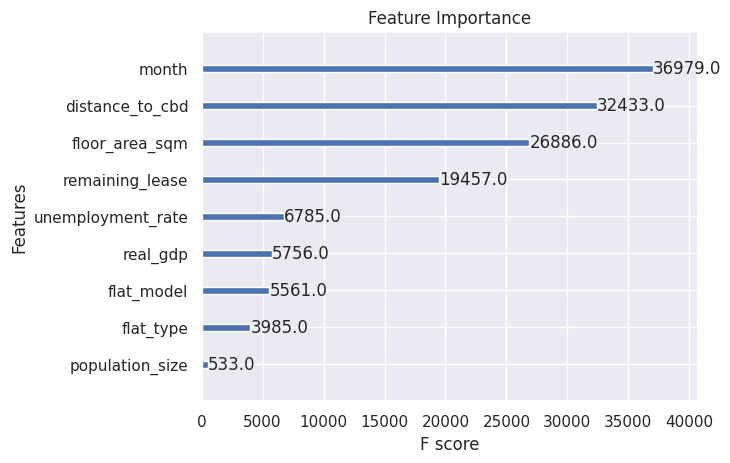

In [19]:
import xgboost as xgb
import matplotlib.pyplot as plt


#'feature_names' is a list of actual feature names
feature_names = ['month', 'flat_type', 'floor_area_sqm', 'flat_model', 'remaining_lease', 'unemployment_rate', 'real_gdp', 'distance_to_cbd', 'population_size']
# Set the feature names on the booster
final_model.get_booster().feature_names = feature_names

# Plot feature importance with updated feature names
xgb.plot_importance(final_model)
plt.title('Feature Importance')
plt.show()


In [20]:
from sklearn.linear_model import LinearRegression
#code for linear regression model
# === HYPERPARAMETER TUNING ===
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, -1],
    'positive': [True, False]
}

lr = LinearRegression()
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search.fit(X_train, y_train)

# === BEST MODEL ===
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best score (Neg MAE):", grid_search.best_score_)

# === VALIDATION PERFORMANCE ===
y_val_pred = best_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = mean_absolute_error(y_val, y_val_pred)
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)
print(f"Validation RMSE: {rmse_val:.2f}")
print(f"Validation MAE: {mae_val:.2f}")
print(f"Validation MAPE: {mape_val:.4f}")

# === RETRAINING ON COMBINED TRAINING AND VALIDATION SETS ===
# Combine raw data
X_combined_raw = np.vstack((X_train_raw, X_val_raw))
y_combined = np.hstack((y_train, y_val))

# Scale combined data
X_combined = scaler.fit_transform(X_combined_raw)

# Retrain model on combined data with best parameters
final_model = LinearRegression(
    fit_intercept=grid_search.best_params_['fit_intercept'],
    copy_X=grid_search.best_params_['copy_X'],
    n_jobs=grid_search.best_params_['n_jobs'],
    positive=grid_search.best_params_['positive']
)
final_model.fit(X_combined, y_combined)

# === TEST PERFORMANCE ===
X_test_scaled = scaler.transform(X_test_raw)
y_test_pred = final_model.predict(X_test_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
print(f"Test RMSE after retraining: {rmse_test:.2f}")
print(f"Test MAE after retraining: {mae_test:.2f}")
print(f"Test MAPE after retraining: {mape_test:.4f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': True}
Best score (Neg MAE): -72599.63462787688
Validation RMSE: 115727.92
Validation MAE: 89299.10
Validation MAPE: 0.1954
Test RMSE after retraining: 122703.64
Test MAE after retraining: 100550.04
Test MAPE after retraining: 0.2497


                     Feature    Importance
2     Feature_floor_area_sqm  53977.631403
6           Feature_real_gdp  43355.856033
1          Feature_flat_type  33759.911018
8    Feature_population_size  29787.537226
7    Feature_distance_to_cbd   8041.804223
4    Feature_remaining_lease    802.043527
0              Feature_month      0.000000
3         Feature_flat_model      0.000000
5  Feature_unemployment_rate      0.000000


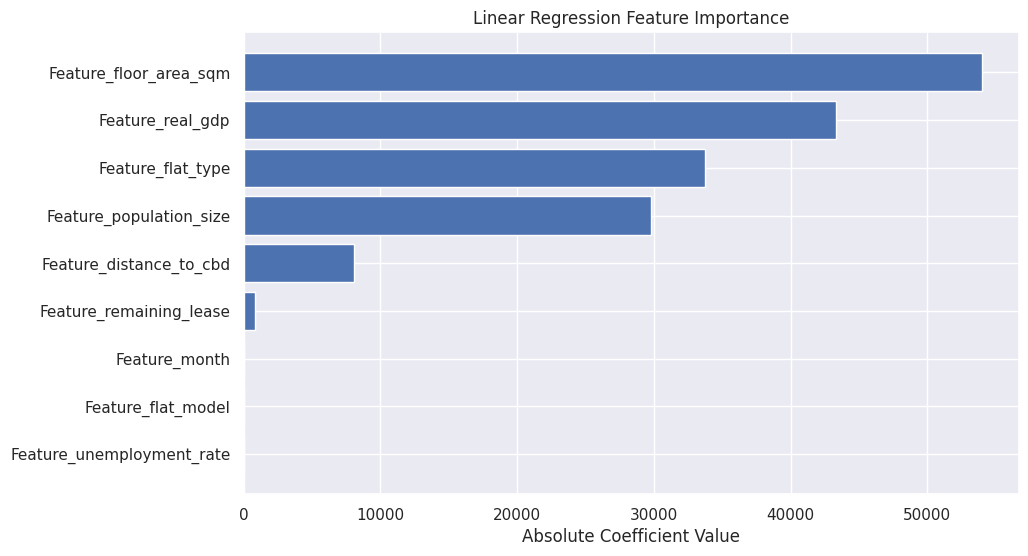

In [21]:
#linear regression visualisation
import matplotlib.pyplot as plt

coefficients = final_model.coef_
#this order was preserved from code block 1 where month, flat_type, floor_area_sqm, flat_model, lease_commence_date, resale_price, unemployment_rate, real_gdp, distance_to_cbd, population_size = 0,1,2,3,4,5,6,7,8,9
feature_liz = ['month', 'flat_type', 'floor_area_sqm', 'flat_model', 'remaining_lease', 'unemployment_rate', 'real_gdp', 'distance_to_cbd', 'population_size']
feature_names = [f'Feature_{feature_liz[i]}' for i in range(len(coefficients))]  # Replace with actual names if available

# Created a DataFrame for better visualization
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)

print(coef_df)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Importance'])
plt.xlabel("Absolute Coefficient Value")
plt.title("Linear Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()
